In [5]:
import sys
sys.path.append("../")
import rg
from rg.graph import incidence_matrix,_delta_
from rg.graph import ring_diagram ,show_spanning_trees
from rg.graph import circuits, set_circuit_flow,set_source_sink_flow,apply_flow
from rg.graph import scalar_propagator
from rg.graph import circuit as cir
import numpy as np
from sympy import * 
init_printing()

In [6]:
inc = incidence_matrix(edges = [ [0,2],[2,3],[0,3],[1,2],[1,3]],  external_vertices=[0,1])
set_source_sink_flow(inc)
inc.flip_edges(1)
ring_diagram(inc)

init exceptions [0, 1, 2, 5, 6]
sourcify 0 along [0 2 5] except [0, 1, 2, 5, 6]
sinkify 1 along [3 4 6] except [5, 6]
sinkify 2 along [0 1 3] except [5, 6, 3, 4]
sinkify 3 along [1 2 4] except [5, 6, 3, 4, 0, 1]


In [7]:
maps = inc.edges_to_loop_basis()
maps[2][1] = -1
maps

init exceptions [0, 1, 2, 5, 6]
sourcify 0 along [0 2 5] except [0, 1, 2, 5, 6]
sinkify 1 along [3 4 6] except [5, 6]
sinkify 2 along [0 1 3] except [5, 6, 3, 4]
sinkify 3 along [1 2 4] except [5, 6, 3, 4, 0, 1]
init exceptions [0, 1, 2, 5, 6]
sourcify 0 along [0 2 5] except [0, 1, 2, 5, 6]
sinkify 1 along [3 4 6] except [5, 6]
sinkify 2 along [0 1 3] except [5, 6, 3, 4]
sinkify 3 along [1 2 4] except [5, 6, 3, 4, 0, 1]


{0: array([-1, -1,  0,  1]),
 1: array([1, 0, 0, 0]),
 2: array([ 1, -1,  0,  0]),
 3: array([ 0, -1,  0,  1]),
 4: array([0, 1, 0, 0])}

In [64]:
#schwiner representation with 
w0 = Symbol("omega_0")
w1 = Symbol("omega_1")
wdash0 = Symbol("omega'_0")
wdash1 = Symbol("omega'_0")
ws = [w0,w1,wdash0,wdash1]

powers = [1,2,2,1,1]
x = [
    [1,0,0,0],
    [0,1,0,0],
    [-1,0,0,0],
    [0,-1,0,0],
    [1,-1,0,0]
]

deltas = [_delta_("alpha", [0,2,4], [1,-1,-1]), _delta_("alpha", [1,3,4], [1,-1,1])]
deltas[1]

$\delta_{1}{\left (\alpha_{1} - \alpha_{3} + \alpha_{4} \right )}$

In [65]:
deltas[0]

$\delta_{0}{\left (\alpha_{0} - \alpha_{2} - \alpha_{4} \right )}$

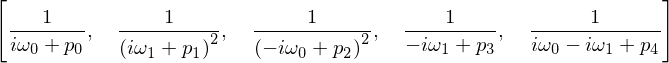

In [66]:
make(x,powers)

In [67]:
def make(x, powers):
    props = []
    for i, r in enumerate(x):
        P = Symbol("p_"+str(i))
        for j, v in enumerate(ws):
            if r[j] != 0: P +=  I*v*r[j] 
        props.append(1/P**powers[i])
    #props = rg._product_(props)
    return props

def schwinger_rep(F): 
    #or try to get odered factors to be the correct size
    factors = F if isinstance(F,list)  else F.as_ordered_factors()
    terms = []
    powers = []
    for i,f in enumerate(factors):
        keys, values = zip(*f.as_powers_dict().items())
        powers.append(values[0])
        terms.append(-1*Symbol("alpha_"+str(i))*keys[0])
    return rg._product_([Symbol("alpha_"+str(i))**(abs(powers[i])-1) for i in range(len(powers))]) * exp(rg._sum_(terms))

def _integrate_(F, deltas):
    F = schwinger_rep(F)
    #apply the deltas functions
    for d in deltas: F = d.apply(F)
    omegas = [I*a for a in F.free_symbols if str(a)[:6] == "omega_"]
    omegas = dict(zip(omegas,[0 for i in range(len(omegas))]))
    F =F.subs(omegas)  
    
    #partition terms
    alpha_terms = []
    exparg = None
    for e in F.as_ordered_factors():
        if isinstance(e, exp): exparg = expand(e.args[0])
        else: alpha_terms.append(e)  
           
    alphas_map = {}
    alphas = [a for a in exparg.free_symbols if str(a)[:5] == "alpha"]
    for a in alphas: alphas_map[a] = -1*exparg.coeff(a)
    
    return expand(rg._product_(alpha_terms)), exparg, alphas_map, F

def s_integrate_and_invert(F,deltas, sum_terms=True):
    prefactor, _, prop_dash, _ = _integrate_(F,deltas)
    #todo need to have a gamma function tool
    terms = []
    out_alphas = list(prop_dash.keys())
    
    for t in prefactor.as_ordered_terms():
        #coefficient of the prefactor term
        cf = list(t.as_coefficients_dict().values())[0]
        powers = t.as_powers_dict()
        #return the term (signed) and get all the kinematics associated with this edge
        trm = cf*rg._product_(1/ (prop_dash[alpha] ** (powers[alpha]+1)) for alpha in out_alphas)
        terms.append(trm)
    
    if sum_terms: terms = rg._sum_(terms)
    return terms, out_alphas


In [68]:
#s_integrate_and_invert(P,deltas)

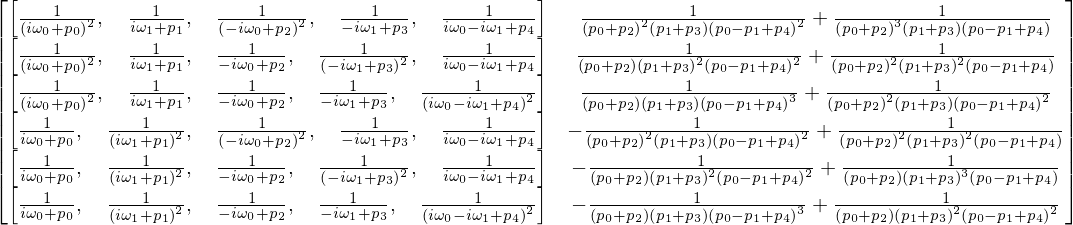

In [69]:
powers = [
    [2,1,2,1,1],
    [2,1,1,2,1],
    [2,1,1,1,2],
    
    [1,2,2,1,1],
    [1,2,1,2,1],
    [1,2,1,1,2],
]

res = []
for p in powers:
    P = make(x, powers=p)
    Q = s_integrate_and_invert(P,deltas)
    res.append([P,Q[0], ])#simplify(Q[0])
    
MRES = Matrix(res)
MRES

In [40]:
powers


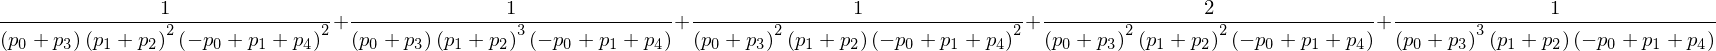

In [42]:
rg._sum_(MRES.col(1))

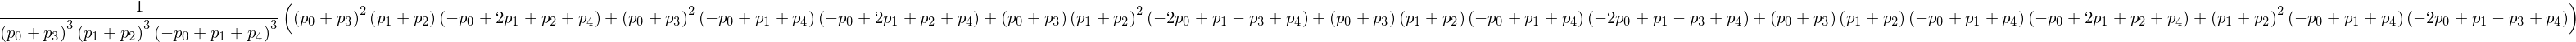

In [26]:
full_thing = simplify(rg._sum_(MRES.col(2)))
full_thing

In [29]:
num_ex = expand(full_thing.as_numer_denom()[0])
num_ex

In [30]:
simplify(num_ex)

In [ ]:
def invert_schwinger_rep(F):  
    def coeff_full(expr,x):
        xterm = [t for t in expr.args if t.has(x)]
        factors = []
        for fac in xterm:  factors+= [t for t in fac.as_ordered_factors() if not t.has(x) and t != -1]      
        return rg._sum_(factors)
        #return factors
    ex_args = {}
    power_args = []
    alpha_signs = {}
    for f in F.as_ordered_factors():
        if isinstance(f,exp):
            f =  f.args[0]
            alphas = [a for a in f.free_symbols if str(a)[:5] == "alpha"]
            omegas = [a for a in f.free_symbols if str(a)[:6] == "omega_"]
            
            #alpha_pref = [v for v in f.as_ordered_terms()[-1].as_ordered_factors() if v.has( alphas[-1])][0]
            #alpha_coeefs = alpha_pref.as_coefficients_dict()
            
            sub_om = dict(zip(omegas,[0 for i in range(len(omegas))]))
            for a in alphas: ex_args[a] = coeff_full(f,a).subs(sub_om) 
        else: power_args.append(f)
            
    #get the pre-factor as a product for which we can determine the power
    power_args = expand(rg._product_(power_args))

    #todo gamma functions
    
    for t in power_args.as_ordered_terms():
        powers = t.as_powers_dict()
        props = []
        for k in ex_args.keys():
            prop = ex_args[k]**(powers[k]+1)
            props.append(1/prop)
        yield rg._product_(props)
#list(invert_schwinger_rep(G))

In [ ]:
def sintegrate(factor, delta_functs):
    
    g = schwinger_rep(factor)
    #return [g]
    for d in delta_functs: g = d.apply(g)
    return [g]
    #for res in invert_schwinger_rep(g):yield res


In [70]:

powermap = [2,1,1,1,2]

L = inc.first_betti_number
factor = rg._product_([scalar_propagator(maps[i][:L], maps[i][L:],species=None,power=powermap[i]).value for i in maps.keys()])
IG = rg.integral(factor)
IG

$\frac{1}{\left(D k_{0}^{2} + i \omega_{0}\right) \left(D k_{1}^{2} + i \omega_{1}\right)^{2} \left(D \left(k'_{1} + k_{1}\right)^{2} + i \omega'_1 - i \omega_{1}\right) \left(D \left(k_{0} + k_{1}\right)^{2} + i \omega_{0} - i \omega_{1}\right) \left(D \left(k'_{1} + k_{0} + k_{1}\right)^{2} + i \omega'_1 - i \omega_{0} - i \omega_{1}\right)^{2}}$

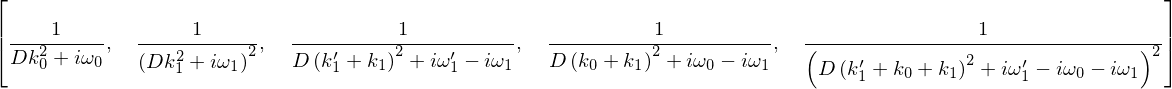

In [73]:
factor.as_ordered_factors()

In [ ]:
deltas = [_delta_("alpha", [1,2,4], [1,-1,-1]), _delta_("alpha", [0,3,4], [1,-1,1])]
L=list(sintegrate(factor,deltas))
L

In [ ]:
F= L
def coeff_full(expr,x):
        xterm = [t for t in expr.args if t.has(x)]
        factors = []
        for fac in xterm:  factors+= [t for t in fac.as_ordered_factors() if not t.has(x) and t != -1]      
        return rg._sum_(factors)
        #return factors
    
ex_args = {}
power_args = []
for f in F.as_ordered_factors():
    if isinstance(f,exp):
        f =  f.args[0]
        alphas = [a for a in f.free_symbols if str(a)[:5] == "alpha"]
        
        alpha_pref = [v for v in f.as_ordered_terms()[-1].as_ordered_factors() if v.has( alphas[-1])][0]
        alpha-coeefs = alpha_pref.as_coefficients_dict()
        
        omegas = [a for a in f.free_symbols if str(a)[:6] == "omega_"]

        sub_om = dict(zip(omegas,[0 for i in range(len(omegas))]))
        for a in alphas: ex_args[a] = coeff_full(f,a).subs(sub_om) 
    else: power_args.append(f)

In [ ]:
f = L[0].as_ordered_factors()[-1].args[0]
alphas = [a for a in f.free_symbols if str(a)[:5] == "alpha"]
omegas = [a for a in f.free_symbols if str(a)[:6] == "omega_"]

sub_om = dict(zip(omegas,[0 for i in range(len(omegas))]))
alphas


In [ ]:
f

In [ ]:
alpha_pref = [v for v in f.as_ordered_terms()[-1].as_ordered_factors() if v.has( alphas[-1])][0]
alpha_pref.as_coefficients_dict()

In [ ]:
f.as_ordered_terms()[-3].as_ordered_factors()

In [ ]:
coeff_full(f,alphas[-1])

In [ ]:
LS = simplify(rg._sum_(L))
LS

In [ ]:
L =  list(sintegrate(factor,deltas))
L

In [ ]:
latex(LS)

In [ ]:
systems = {}
systems["  r0"] = lambda : incidence_matrix(edges =[ [0,1], [1,2], [2,0] ],external_vertices=[0,1])
systems["  r1"] = lambda :incidence_matrix(edges = [ [0,1], [0,2], [1,4], [2,3], [3,4], [4,5],[3,5] ],external_vertices=[0,1])
systems["  r2"] = lambda :incidence_matrix(edges = [ [0,2],[2,1],[0,3], [1,4], [3,5],[3,4],[4,5] ],external_vertices=[0,1])
systems["  r3"] = lambda :incidence_matrix(edges = [ [0,1],[0,2],[1,3], [3,4], [3,5],[2,4],[2,5] ], external_vertices=[0,1])
systems["  r4"] = lambda :incidence_matrix(edges = [ [0,1],[0,2],[2,3], [3,4], [4,1],[2,5],[5,3] ], external_vertices=[0,1])
systems["  r5"] = lambda :incidence_matrix(edges = [ [0,1],[0,2],[1,3], [2,3], [3,2] ], external_vertices=[0,1])
systems["  r6"] = lambda :incidence_matrix(edges = [ [0,2],[2,1],[0,3], [3,4], [1,5], [4,5], [5,4] ],  external_vertices=[0,1])
systems["  r7"] = lambda :incidence_matrix(edges = [ [0,2], [2,3], [3,1], [1,4], [4,5], [0,4], [5,3] ],  external_vertices=[0,1])
systems["  r8"] = lambda :incidence_matrix(edges = [ [0,2],[2,3],[3,1],[1,5],[5,4],[4,3],[4,0] ], external_vertices=[0,1])
systems["  r9"] = lambda :incidence_matrix(edges = [ [0,2],[2,3],[3,4],[4,1],[1,5],[5,3],[5,0] ], external_vertices=[0,1])
systems["  r10"]= lambda :incidence_matrix(edges = [ [0,2],[2,3],[3,1],[1,4],[4,5],[5,2],[4,0] ],  external_vertices=[0,1])
systems["  r11"]= lambda :incidence_matrix(edges = [ [0,2],[2,3],[3,1],[1,4],[4,3],[4,5],[5,0] ], external_vertices=[0,1])

systems[" c0"] = lambda :incidence_matrix(edges = [ [0,2],[2,1],[0,3], [3,1] ], external_vertices=[0,1])
systems[" c1"] = lambda :incidence_matrix(edges = [ [0,2],[2,1],[0,3], [4,1], [3,5], [3,6], [4,5], [4,6] ],  external_vertices=[0,1])
systems[" c2"] = lambda :incidence_matrix(edges = [ [0,2],[2,1],[1,4], [4,5], [0,3], [5,3], [3,6], [5,6] ],  external_vertices=[0,1])
systems[" c3"] = lambda :incidence_matrix(edges = [ [0,2],[2,1], [1,4], [3,5], [4,6], [6,5], [5,6],[0,3] ], external_vertices=[0,1])
systems[" c4"] = lambda :incidence_matrix(edges = [ [0,2],[2,3], [1,4], [3,4], [1,5], [6,5], [6,3],[0,6] ], external_vertices=[0,1])
systems[" c5"] = lambda :incidence_matrix(edges = [ [0,2],[2,3], [1,3], [1,4], [4,5], [6,5], [6,3],[0,5] ], external_vertices=[0,1])
systems[" c6"] = lambda :incidence_matrix(edges = [ [0,2],[2,3], [1,3], [1,4], [4,5], [6,5], [6,2],[0,5] ],  external_vertices=[0,1])

systems["r0Andc0Compact"] = lambda :incidence_matrix(edges = [ [0,1], [1,0] ],external_vertices=[0,1])
systems["r1TOr6Andc1TOc3Compact"] = lambda :incidence_matrix(edges = [ [0,1], [0,2], [1,3], [2,3], [3,2] ],external_vertices=[0,1])
systems["r7TOr11Andc4TOc6Compact"] = lambda :incidence_matrix(edges = [ [0,2],[2,3],[0,3],[1,2],[1,3]],  external_vertices=[0,1])

## write them to a file

In [ ]:
import cairosvg

H = """\\documentclass[]{article}
\\usepackage[margin=0.5in]{geometry}
\\usepackage{amsmath}
\\usepackage{breqn}
\\usepackage{graphics}
\\usepackage{mathtools}
\\begin{document}"""
with open("systems.tex", "w") as f:
    f.write(H)
    keys = sorted(list(systems.keys()))
    for k in keys:
        f.write("\\section{"+k+"}")
        S = systems[k]()
        set_source_sink_flow(S)
        
        somesvg = ring_diagram(S, options={"show_labels"}).__display__()
        cairosvg.svg2pdf(somesvg, write_to='./sample_data/{}.pdf'.format(k.strip()))

        LHS = """\\vcenter{\\hbox{\\includegraphics[scale=0.7]{sample_data/"""+k.strip()+"""}}}="""
        f.write( "\\begin{dmath*} "+ LHS+str(latex(Matrix(S))) +"\\end{dmath*} ")
        
        a,b=S._symanzik_pols_(True,True,False,use_zero_mass=True)
        a_,b_=S._symanzik_pols_(True,True,True,use_zero_mass=True)
        
        f.write( "\\begin{dmath*} \Psi= "+ str(latex(simplify(a))) +"\\end{dmath*} ")
        f.write( "\\begin{dmath*} \Psi'= "+ str(latex(simplify(a_))) +"\\end{dmath*} ")
        f.write( "\\begin{dmath*} \Phi="+ str(latex(simplify(b))) +"\\end{dmath*} ")
        f.write( "\\begin{dmath*} \Phi'="+ str(latex(simplify(b_))) +"\\end{dmath*} ")

    f.write("""\\end{document}""")